# Making A Twitter Bot: Part 1

Today we will also be using the [Tween library](https://www.tweepy.org/) to access the twitter API, You can also have a look at this the [tutorial](https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9#:~:text=If%20you%20want%20to%20create,with%20Read%20and%20Write%20permissions) for guidance n the library.

There have been some changes to the Twitter API will work you thorough how to get [free access]( https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api)  via

In [1]:
# Grouping Python imports
# 1. standard (built-in) libraries - the ones we don't need to install
from io import BytesIO

# 2. third-party libraries (the ones we install using pip or conda)
import freetype as F
import matplotlib.pyplot as plt
import numpy as np
import requests
import tweepy

from bs4 import BeautifulSoup
from PIL import Image

# 3. custom libraries (from our own files)
import configSiftr as config # EDIT WITH YOUR OWN CONFIG FILE NAME


The access tokens and keys below come from your developer portal at [developer.twitter.com](https://developer.twitter.com/en). and have been entered in the config file of the week's project

In [2]:
# important: set the app permissions first, then regenerate the access tokens!
client = tweepy.Client(
    bearer_token=config.bearer_token,
    consumer_key=config.api_key,
    consumer_secret=config.api_key_secret,
    access_token=config.access_token,
    access_token_secret=config.access_token_secret,
)

In [3]:
tweepy.__version__

'4.14.0'

### Adding a tweet using the Tween Library

In [4]:
# NOTE: if this does not work in VSCode, try running the notebook in the browser
response = client.create_tweet(text='Hello world \nthis is a test')
print(response)

Response(data={'edit_history_tweet_ids': ['1790479400368042492'], 'id': '1790479400368042492', 'text': 'Hello world \n this is a test'}, includes={}, errors=[], meta={})


## Recap on methods to create Ascii Art

In [5]:
def get_sorted_chars(text):
    ## converts the raw text to a set of characters
    no_repeats = set(text)
    # Loads the font file from the folder. Make sure the file is also in the my-practice folder
    # where you are running your own notebook
    f = F.Face('Ubuntu-M.ttf')
    f.set_char_size(99)
    sorted_chars = sorted([(f.load_char(c) or sum(f.glyph.bitmap.buffer) ,c)for c in no_repeats])
    return sorted_chars

In [6]:
def download_img(url):
     # sample info about user agent, which Wikipedia requires (though it's not always executed)
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    response = requests.get(url, headers=headers, stream=True)
    return Image.open(BytesIO(response.content))

In [7]:
def img_2_ascii(img, chars):
    step = 1 / len(chars)
    grayscale = img.convert(mode="L")
    # unfortunately the size can't be bigger due to tweet lentgth limit
    resized = grayscale.resize(size=(20, 12), resample=Image.Resampling.NEAREST)
    resized_array = np.array(resized)
    ascii_img = []
    
    for row in resized_array:
        ascii_row = []
        for col in row:
            scaled = col / 255
            # mapping the pixel value to the character index in the
            idx = max(0, int(scaled / step) - 1)
            ascii_row.append(chars[idx][1])
        ascii_img.append(ascii_row)
    return ascii_img

In [8]:
img = download_img('https://pbs.twimg.com/media/FSUvik-XIAE4lxJ.jpg')

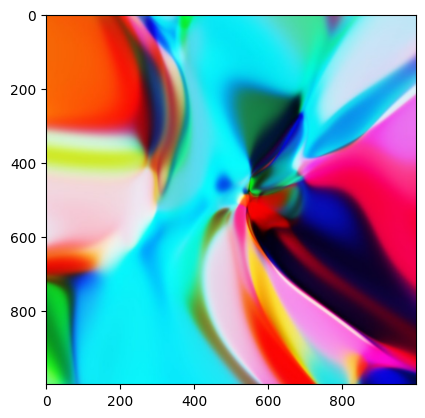

In [9]:
plt.imshow(img)

In [ ]:
sorted_chars = get_sorted_chars("This }{;',.?'} is some 234 rando&m text w1th s0m3 num83rs")

In [ ]:
ascii_img = img_2_ascii(img, sorted_chars)

In [ ]:
def show_ascii_img(ascii_img):
    for row in ascii_img:
        print("".join(row))

In [ ]:
show_ascii_img(ascii_img)

## Recap we are going to scrape Wikipedia for Images

In [ ]:
def link_is_valid(link):
    required_types = ['png', 'jpg', 'jpeg']
    if link.startswith('/wiki/') or link.startswith('//upload.wikimedia.org') :
        valid = False
        for type in required_types:
            if type  in link:
                valid = True
                break
    return valid


def get_links(soup):
    links = []
    for a in soup.find_all("a"):
        try:
            link = a["href"]
            if link_is_valid(link):
                links.append(link)
        except:
            pass

    return links

def get_picture_links(soup):
    links = []
    for div in soup.find_all("div",class_="fullImageLink"):
        children = div.findChildren("a" , recursive=False)
        for child in children:
            #print(child)
            try:
                link = child["href"]
                if link_is_valid(link):
                    links.append(link)
            except:
                pass
    return links

## Web Scraping Recap

 We are going to web scrap wikipedia given a word

In [ ]:
query_word = 'cat'
url = 'https://en.wikipedia.org/wiki/' + query_word
page = requests.get(url)
soup = BeautifulSoup(page.content, features="html.parser")
links = list(set(get_links(soup)))
print(links)

In the below we are going to get all the paragraph tag text associated with the wiki page

In [ ]:
p_tags = soup.find_all(['p'])
html_p_tag_text = ' '.join([p_tag.text for p_tag in p_tags])
# clean text
escapes = ''.join([chr(char) for char in range(1, 32)])
translator = str.maketrans('', '', escapes)
cleaned_html_p_tag_text = html_p_tag_text.translate(translator)

We are then going to find the source of all the images on the wiki page

In [ ]:
def get_image_from_url(url):
    page = requests.get(url, stream=True)
    soup = BeautifulSoup(page.content, features="html.parser")
    picture_links = get_picture_links(soup)
    return picture_links

In [ ]:
all_picture_links = []
for l in links:
    link_url = 'https://en.wikipedia.org' + l
    all_picture_links.extend(get_image_from_url(link_url))

In [ ]:
all_picture_links_cleaned = []
for  l in all_picture_links:
    all_picture_links_cleaned.append('https:' + l)

In [ ]:
all_picture_links_cleaned

we are then going to pic a random picture and convert to ascii image

In [ ]:
img_url = all_picture_links_cleaned[8]
img = download_img(img_url)
plt.imshow(img)

In [ ]:
sorted_chars = get_sorted_chars(cleaned_html_p_tag_text)
ascii_img = img_2_ascii(img, sorted_chars)

In [ ]:
print(ascii_img)

In [ ]:
show_ascii_img(ascii_img)

In [ ]:
def ascii_2_tweet(ascii_img):
    rows = ["".join(row) for row in ascii_img]
    return "\n".join(rows)

In [ ]:
ascii_2_tweet(ascii_img)

In [ ]:
tweet = ascii_2_tweet(ascii_img)

In [ ]:
response = client.create_tweet(text=tweet)
print(response)